# Tutorial3: Reannotation on scST data (with pre-annoated info)

STAMapper exhibited capabilities surpassing manual annotation. For cells exhibit labeling discrepancies between manual annotation and STAMapper, the corresponding markers showed highly consistent with the annotation of STAMapper. Here utilized MERFISH mouse hypothalamic data (ID=15) to show this result, The scRNA-seq dataset and the scST dataset can be download from [Google Drive](https://drive.google.com/drive/folders/1xP3Fh94AwKu4OsH3khGq-KEw0VCoiRnL) (MERFISH_hypothalamic.zip).

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import scanpy as sc
import os
import shutil
from matplotlib.colors import LinearSegmentedColormap
from STAMapper import pipeline, pp, pl
import warnings
warnings.filterwarnings("ignore")

In [2]:
key_class1 = 'celltype'#celltype label for adata_sc, stored in adata_sc.obs[key_class1]
key_class2 = 'celltype'#celltype label for adata_sp, stoted in adata_sp.obs[key_class2]
key_classes = [key_class1, key_class2]

## Load data

In [3]:
adata_sc = sc.read_h5ad(r'../data/hypothalamic_sc.h5ad')
adata_sp = sc.read_h5ad(r'../data/MERFISH_hypothalamic_15.h5ad') 

sc_name = 'hypothalamic_sc'
sp_name = 'hypothalamic_MERFISH_reannotation'

#change dsnames for a new training task
dsnames = (sc_name, sp_name)

#delete dirs for old task with the same dsnames
if os.path.exists(Path(".") /'_temp' / f'{dsnames}'):
    shutil.rmtree(Path(".") /'_temp' / f'{dsnames}')

## Training

In [4]:
adatas = [adata_sc, adata_sp]
outputs = pipeline.training(adatas=adatas, dsnames=dsnames, key_classes=key_classes)

Data Preprocessing!
[leiden] Time used:  151.8786 s
a new directory made:
	_temp\('hypothalamic_sc', 'hypothalamic_MERFISH_reannotation')\0\figs
already exists:
	_temp\('hypothalamic_sc', 'hypothalamic_MERFISH_reannotation')\0
[*] Setting dataset names:
	0-->hypothalamic_sc
	1-->hypothalamic_MERFISH_reannotation
[*] Setting aligned features for observation nodes (self._features)
[*] Setting observation-by-variable adjacent matrices (`self._ov_adjs`) for making merged graph adjacent matrix of observation and variable nodes
-------------------- Summary of the DGL-Heterograph --------------------
Graph(num_nodes={'cell': 48956, 'gene': 154},
      num_edges={('cell', 'express', 'gene'): 1451057, ('cell', 'self_loop_cell', 'cell'): 48956, ('cell', 'similar_to', 'cell'): 315392, ('gene', 'expressed_by', 'cell'): 1451057, ('gene', 'self_loop_gene', 'gene'): 154},
      metagraph=[('cell', 'gene', 'express'), ('cell', 'cell', 'self_loop_cell'), ('cell', 'cell', 'similar_to'), ('gene', 'cell',

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 21.13it/s]


object saved into:
	 _temp\('hypothalamic_sc', 'hypothalamic_MERFISH_reannotation')\0\datapair_init.pickle


## Check accuracy

In [5]:
folder_path = Path(".") /'_temp' / f'{dsnames}'
best_model, accuracy, macrof1, weightedf1 = pp.calc_scores(folder_path, key_class2)
print(f"Best Model: {best_model}, Accuracy: {accuracy:.3f}, Macro F1 Score: {macrof1:.3f}, Weighted F1 Score: {weightedf1:.3f}")

Best Model: 0, Accuracy: 0.867, Macro F1 Score: 0.592, Weighted F1 Score: 0.868


 ## Visualization

In [6]:
obs = pd.read_csv(folder_path/f'{best_model}'/'obs.csv',index_col=0)
obs = obs[obs['dataset'].isin([sp_name])]
adata_sp.obs['predicted'] = list(obs['predicted'])

In [7]:
sc.pp.normalize_total(adata_sp, target_sum=1e4)
sc.pp.log1p(adata_sp)
adata_sp.raw = adata_sp
#sc.pp.scale(adata_sp, max_value=10)#optional
sc.tl.pca(adata_sp, svd_solver="arpack")
sc.pp.neighbors(adata_sp, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_sp)

Compare maunal annotation(upper panel) with predicted (lower panel).

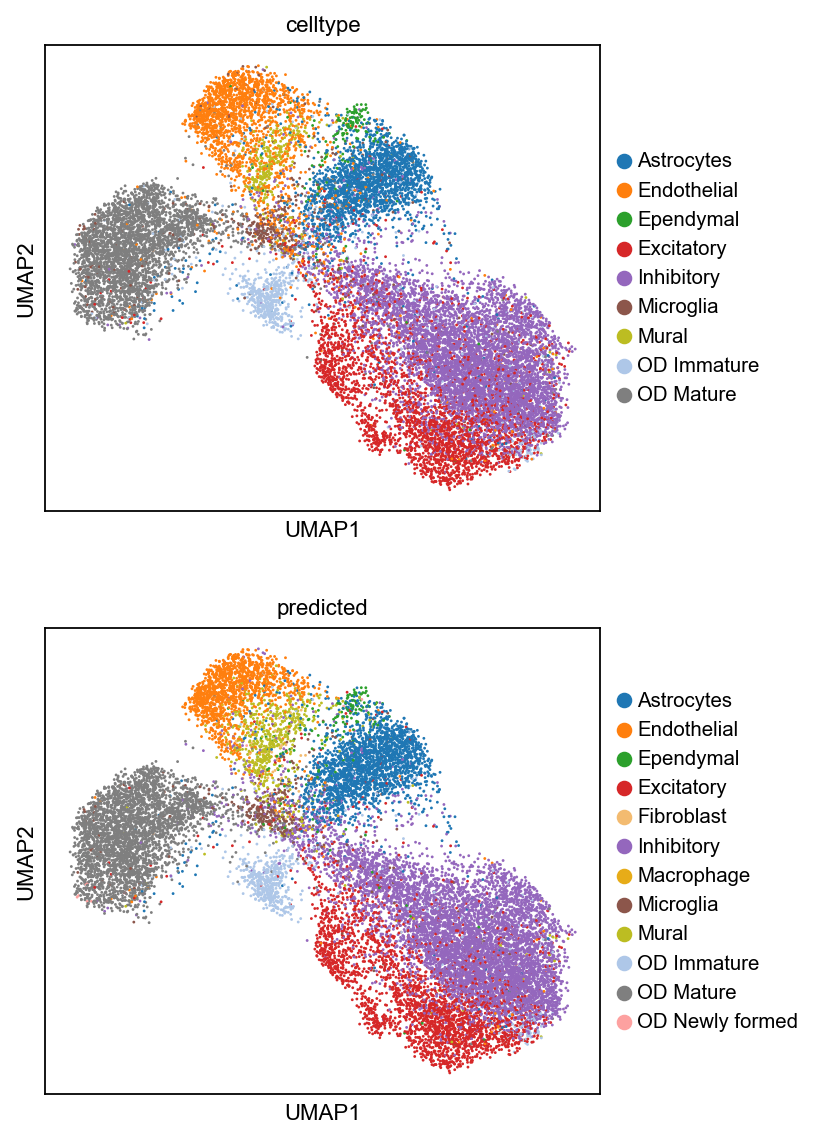

In [8]:
palette = {'Astrocytes': '#1f77b4',
 'Inhibitory': '#9467bd',
 'Endothelial': '#ff7f0e',
 'Ependymal': '#2ca02c',
 'Excitatory': '#d62728',
 'Fibroblast': '#f3bb70',
 'Macrophage': '#e7ac18',
 'Microglia': '#8c564b',
 'Mural': '#bcbd22',
 'OD Immature': '#aec7e8',
 'OD Mature': '#7f7f7f',
 'OD Newly formed': '#fda1a0'}

sc.pl.umap(adata_sp, color=["celltype", "predicted"], ncols=1, palette=palette)

## Visualize expression of  marker genes on major cell types

In [26]:
obs_mismatch = adata_sp.obs[np.array(adata_sp.obs['celltype'])!=np.array(adata_sp.obs['predicted'])]
adata_sp2 = adata_sp[obs_mismatch.index,:]
adata_sp3 = adata_sp2[~adata_sp2.obs['predicted'].isin(['OD Newly formed','Fibroblast','Macrophage'])]

Cells exhibited labeling discrepancies groupby manual annotation.


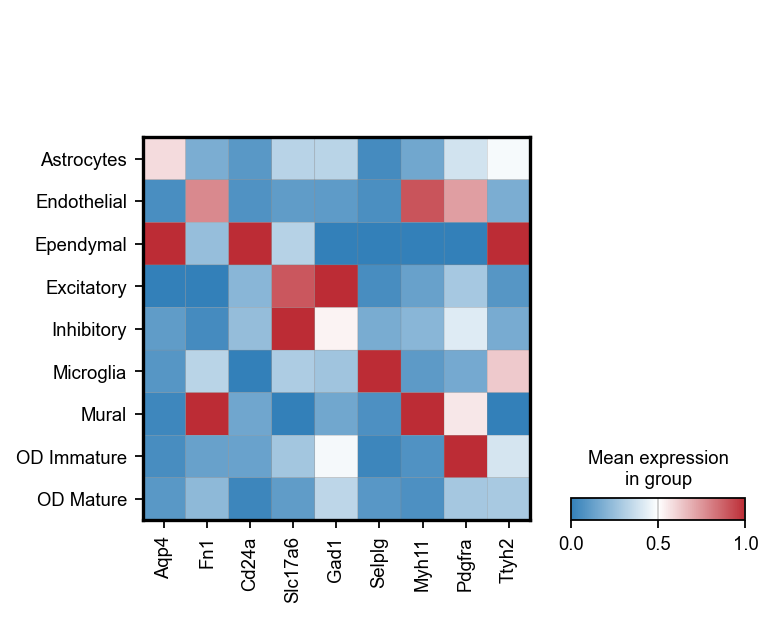

In [32]:
colors = ["#3380b9", "#ffffff", "#bc2c35"]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
print('Cells exhibited labeling discrepancies groupby manual annotation.')
sc.pl.matrixplot(adata_sp3, cmap=custom_cmap, groupby='celltype', var_names=['Aqp4','Fn1','Cd24a','Slc17a6','Gad1','Selplg','Myh11','Pdgfra','Ttyh2'], standard_scale='var')

Cells exhibited labeling discrepancies groupby STAMapper annotation.


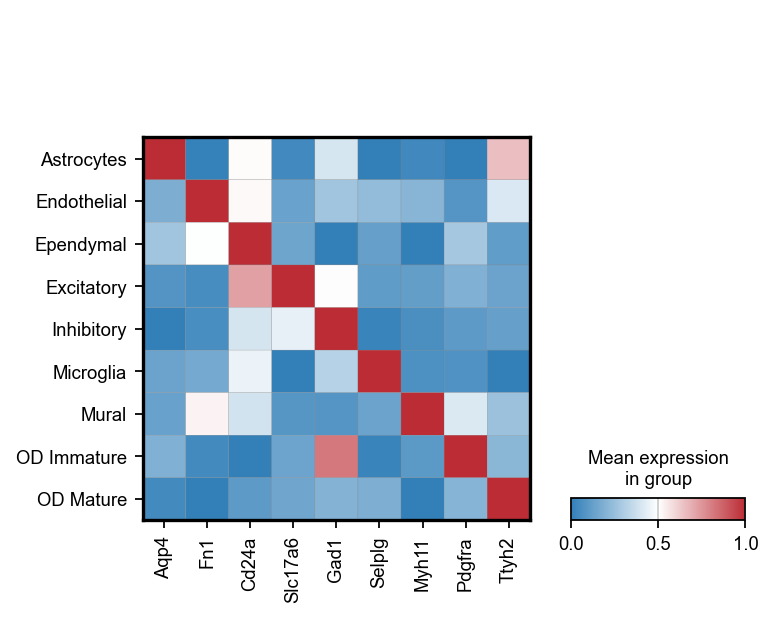

In [31]:
print('Cells exhibited labeling discrepancies groupby STAMapper annotation.')
sc.pl.matrixplot(adata_sp3, cmap=custom_cmap, groupby='predicted', var_names=['Aqp4','Fn1','Cd24a','Slc17a6','Gad1','Selplg','Myh11','Pdgfra','Ttyh2'], standard_scale='var')